# EDA, Preprocessing and Modelling using Core Dataset and MRT station data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import csv as csv
import sklearn
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score,KFold,train_test_split,GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import xgboost
import lightgbm as lgb

from utils import save_to_csv, reduce_memory_usage,custom_kfold_scorer 

## Loading dataset

In [3]:
train_df = pd.read_csv("./train_2.csv")
test_df = pd.read_csv("./test_2.csv")
mrt_df = pd.read_csv("./auxiliary-data/sg-train-stations.csv")

In [4]:
mrt_df.head()

,name,codes,lat,lng,opening_year,type
0,Eunos,EW7,1.319778,103.903252,1989.0,mrt
1,Chinese Garden,EW25,1.342352,103.732596,1988.0,mrt
2,Khatib,NS14,1.417383,103.832980,1988.0,mrt
3,Kranji,NS7,1.425177,103.762165,1996.0,mrt
4,Redhill,EW18,1.289562,103.816816,1988.0,mrt


In [5]:
mrt_df.isnull().any()
mrt_df['type'].unique()

array(['mrt', 'other'], dtype=object)

There are some null values. We will drop all the datapoints with null values. LRT station with type="other" have null values in opening year. So in essence we are dropping all LRT stations from analysis.

In [6]:
mrt_df = mrt_df.dropna()
mrt_df['type'].unique()

array(['mrt'], dtype=object)

In [7]:
mrt_df.isnull().any()

name            False
codes           False
lat             False
lng             False
opening_year    False
type            False
dtype: bool

In [8]:
print("Min opening year of mrt station : ",mrt_df['opening_year'].min())
print("Max opening year of mrt station : ",mrt_df['opening_year'].max())

Min opening year of mrt station :  1987.0
Max opening year of mrt station :  2031.0


In [9]:
print("Min resale year of hdb : ",train_df['year'].min())
print("Max resale year of hdb : ",train_df['year'].max())

Min resale year of hdb :  2000
Max resale year of hdb :  2020


### Checking for duplicate values

In [10]:
mrt_df.duplicated().any()

False

### Distribution of HDB flats and MRT stations

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

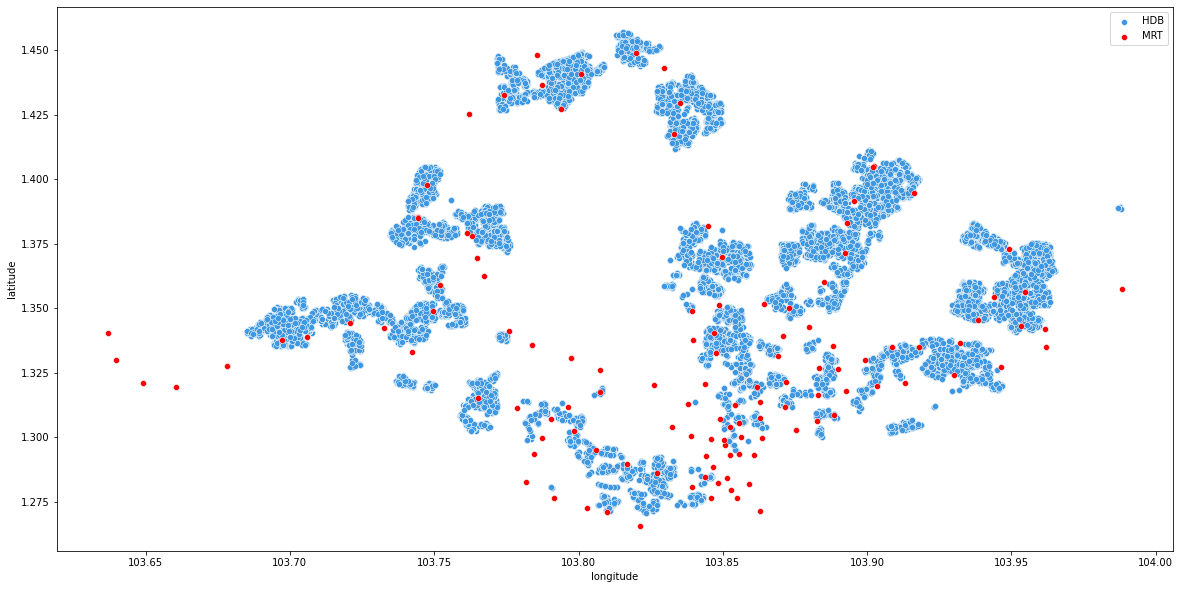

In [11]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=train_df.longitude,y=train_df.latitude,color="#3E97E0",label="HDB")
sns.scatterplot(x=mrt_df.lng,y=mrt_df.lat,color="#FC0000",label="MRT")

### Club latitude and longitude together and drop 'lat' and 'lng' columns and other not-required columns

In [12]:
mrt_df['lat_long'] = list(zip(mrt_df.lat, mrt_df.lng))

In [13]:
mrt_df = mrt_df.drop(columns=['lat','lng','codes','type'])

In [14]:
mrt_df.head()

,name,opening_year,lat_long
0,Eunos,1989.0,"(1.3197782848869883, 103.90325213335886)"
1,Chinese Garden,1988.0,"(1.3423521542087522, 103.73259640485368)"
2,Khatib,1988.0,"(1.4173827034869275, 103.8329795744054)"
3,Kranji,1996.0,"(1.4251770321043908, 103.76216507762184)"
4,Redhill,1988.0,"(1.2895620597351771, 103.81681633682066)"


### Extract lat_long and year columns from train and test data sets

In [15]:
train_df_temp = train_df[["lat_long", "year"]]
test_df_temp = test_df[["lat_long", "year"]]

### Drop duplicate locations

In [16]:
train_df_temp = train_df_temp.drop_duplicates(subset=['lat_long'])
test_df_temp = test_df_temp.drop_duplicates(subset=['lat_long'])

### Add columns to store the nearest mrt and its distance

In [17]:
train_df_temp["nearest_mrt"] = str("--")
train_df_temp["nearest_mrt_distance"] = math.inf
test_df_temp["nearest_mrt"] = str("--")
test_df_temp["nearest_mrt_distance"] = math.inf
train_df_temp = train_df_temp.reset_index()
test_df_temp = test_df_temp.reset_index()

In [18]:
mrt_df = mrt_df.reset_index()

In [19]:
mrt_df.head()

,index,name,opening_year,lat_long
0,0,Eunos,1989.0,"(1.3197782848869883, 103.90325213335886)"
1,1,Chinese Garden,1988.0,"(1.3423521542087522, 103.73259640485368)"
2,2,Khatib,1988.0,"(1.4173827034869275, 103.8329795744054)"
3,3,Kranji,1996.0,"(1.4251770321043908, 103.76216507762184)"
4,4,Redhill,1988.0,"(1.2895620597351771, 103.81681633682066)"


In [20]:
train_df_temp.head()

,index,lat_long,year,nearest_mrt,nearest_mrt_distance
0,0,"(1.3690080642700195, 103.95869445800781)",2001,--,inf
1,1,"(1.3990070819854736, 103.90699005126953)",2014,--,inf
2,2,"(1.3883482217788696, 103.87381744384766)",2020,--,inf
3,3,"(1.3184930086135864, 103.7667007446289)",2000,--,inf
4,4,"(1.3481495380401611, 103.74266052246094)",2013,--,inf


In [21]:
test_df_temp.head()

,index,lat_long,year,nearest_mrt,nearest_mrt_distance
0,0,"(1.3465807437896729, 103.74408721923828)",2004,--,inf
1,1,"(1.3576176166534424, 103.96138000488281)",2001,--,inf
2,2,"(1.337803840637207, 103.74199676513672)",2002,--,inf
3,3,"(1.380083680152893, 103.84957122802734)",2015,--,inf
4,4,"(1.3139597177505493, 103.76982879638672)",2004,--,inf


### Converting our dataframe to numpy arrays for faster computation of distances

In [22]:
train_df_temp_numpy = train_df_temp.to_numpy()
test_df_temp_numpy = test_df_temp.to_numpy()
mrt_df_numpy = mrt_df.to_numpy()

In [23]:
print("Shape of train_df_temp_numpy :",np.shape(train_df_temp_numpy))
print("Shape of test_df_temp_numpy :",np.shape(test_df_temp_numpy))
print("Shape of mrt_df_numpy :",np.shape(mrt_df_numpy))

Shape of train_df_temp_numpy : (9138, 5)
Shape of test_df_temp_numpy : (8990, 5)
Shape of mrt_df_numpy : (126, 4)


### Find distance of nearest MRT

In [24]:
%%time
print("Get distance for each location and update nearest mrt and its distance")
for i in range(len(train_df_temp_numpy)):
    min_dist = math.inf
    min_dist_mrt = ""
    hdb_location = train_df_temp_numpy[i][1]
    hdb_location = eval(hdb_location)
    resale_year = train_df_temp_numpy[i][2]
    for j in range(len(mrt_df_numpy)):
        opening_year = mrt_df_numpy[j][2]
        if opening_year <= resale_year:
            mrt_location = mrt_df_numpy[j][3]
            distance = geopy.distance.great_circle(hdb_location, mrt_location).km
            if distance < min_dist:
                min_dist = distance
                min_dist_mrt = mrt_df_numpy[j][1]
    train_df_temp_numpy[i][3] = min_dist_mrt
    train_df_temp_numpy[i][4] = min_dist

print("Add nearest_mrt and nearest_mrt_distance to dataframe")
for i in range(len(train_df_temp_numpy)):
    dataframe_index = train_df_temp_numpy[i][0]
    train_df_temp.loc[i, "nearest_mrt"] = train_df_temp_numpy[i][3]
    train_df_temp.loc[i, "nearest_mrt_distance"] = train_df_temp_numpy[i][4]

Get distance for each location and update nearest mrt and its distance
Add nearest_mrt and nearest_mrt_distance to dataframe
Wall time: 12.1 s


In [25]:
%%time
print("Get distance for each location and update nearest mrt and its distance")
for i in range(len(test_df_temp_numpy)):
    min_dist = math.inf
    min_dist_mrt = ""
    hdb_location = test_df_temp_numpy[i][1]
    hdb_location = eval(hdb_location)
    resale_year = train_df_temp_numpy[i][2]
    for j in range(len(mrt_df_numpy)):
        opening_year = mrt_df_numpy[j][2]
        if opening_year <= resale_year:
            mrt_location = mrt_df_numpy[j][3]
            distance = geopy.distance.great_circle(hdb_location, mrt_location).km
            if distance < min_dist:
                min_dist = distance
                min_dist_mrt = mrt_df_numpy[j][1]
    test_df_temp_numpy[i][3] = min_dist_mrt
    test_df_temp_numpy[i][4] = min_dist

print("Add nearest_mrt and nearest_mrt_distance to dataframe")
for i in range(len(test_df_temp_numpy)):
    dataframe_index = test_df_temp_numpy[i][0]
    test_df_temp.loc[i, "nearest_mrt"] = test_df_temp_numpy[i][3]
    test_df_temp.loc[i, "nearest_mrt_distance"] = test_df_temp_numpy[i][4]

Get distance for each location and update nearest mrt and its distance
Add nearest_mrt and nearest_mrt_distance to dataframe
Wall time: 11.9 s


In [26]:
train_df_temp.head()

,index,lat_long,year,nearest_mrt,nearest_mrt_distance
0,0,"(1.3690080642700195, 103.95869445800781)",2001,Pasir Ris,1.137305
1,1,"(1.3990070819854736, 103.90699005126953)",2014,Punggol,0.823520
2,2,"(1.3883482217788696, 103.87381744384766)",2020,Buangkok,2.230426
3,3,"(1.3184930086135864, 103.7667007446289)",2000,Clementi,0.423286
4,4,"(1.3481495380401611, 103.74266052246094)",2013,Bukit Batok,0.773956


In [27]:
test_df_temp.head()

,index,lat_long,year,nearest_mrt,nearest_mrt_distance
0,0,"(1.3465807437896729, 103.74408721923828)",2004,Bukit Batok,0.667364
1,1,"(1.3576176166534424, 103.96138000488281)",2001,Simei,1.833560
2,2,"(1.337803840637207, 103.74199676513672)",2002,Jurong East,0.518267
3,3,"(1.380083680152893, 103.84957122802734)",2015,Yio Chu Kang,0.546624
4,4,"(1.3139597177505493, 103.76982879638672)",2004,Clementi,0.515598


### We will now merge the result with our original data frames

In [28]:
temp = train_df_temp[["lat_long", "nearest_mrt", "nearest_mrt_distance"]]
train_df = pd.merge(train_df, temp, on="lat_long", how='left')
print("Changing datatype of nearest_mrt_distance to float32")
train_df[['nearest_mrt_distance']] = train_df[['nearest_mrt_distance']].astype('float32')

temp = test_df_temp[["lat_long", "nearest_mrt", "nearest_mrt_distance"]]
test_df = pd.merge(test_df, temp, on="lat_long", how='left')
print("Changing datatype of nearest_mrt_distance to float32")
test_df[['nearest_mrt_distance']] = test_df[['nearest_mrt_distance']].astype('float32')

Changing datatype of nearest_mrt_distance to float32
Changing datatype of nearest_mrt_distance to float32


### Nearest MRT and its distance from HDB has been added to our dataframe

In [29]:
train_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,subzone,planning_area,region,resale_price,month_no,year,storey,lat_long,nearest_mrt,nearest_mrt_distance
0,pasir ris,4-room,440,pasir ris drive 4,118.0,model a,1989,1.369008,103.958694,pasir ris drive,pasir ris,east region,209700.0,8,2001,2.0,"(1.3690080642700195, 103.95869445800781)",Pasir Ris,1.137305
1,punggol,5-room,196B,punggol field,110.0,improved,2003,1.399007,103.906990,punggol field,punggol,north-east region,402300.0,10,2014,11.0,"(1.3990070819854736, 103.90699005126953)",Punggol,0.823520
2,sengkang,5-room,404A,fernvale lane,112.0,premium apartment,2004,1.388348,103.873820,fernvale,sengkang,north-east region,351000.0,9,2020,2.0,"(1.3883482217788696, 103.87381744384766)",Buangkok,2.230426
3,clementi,3-room,375,clementi avenue 4,67.0,new generation,1980,1.318493,103.766700,clementi north,clementi,west region,151200.0,10,2000,8.0,"(1.3184930086135864, 103.7667007446289)",Clementi,0.423286
4,bukit batok,3-room,163,bukit batok street 11,73.0,model a,1985,1.348150,103.742660,bukit batok west,bukit batok,west region,318600.0,1,2013,8.0,"(1.3481495380401611, 103.74266052246094)",Bukit Batok,0.773956


In [30]:
test_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,subzone,planning_area,region,month_no,year,storey,lat_long,nearest_mrt,nearest_mrt_distance
0,bukit batok,4-room,186,bukit batok west avenue 6,94.0,new generation,1989,1.346581,103.74409,bukit batok west,bukit batok,west region,1,2004,5.0,"(1.3465807437896729, 103.74408721923828)",Bukit Batok,0.667364
1,tampines,5-room,366,tampines street 34,122.0,improved,1997,1.357618,103.96138,tampines east,tampines,east region,11,2001,5.0,"(1.3576176166534424, 103.96138000488281)",Simei,1.833560
2,jurong east,3-room,206,jurong east street 21,67.0,new generation,1982,1.337804,103.74200,toh guan,jurong east,west region,7,2002,2.0,"(1.337803840637207, 103.74199676513672)",Jurong East,0.518267
3,ang mo kio,3-room,180,Ang Mo Kio Avenue 5,82.0,new generation,1981,1.380084,103.84957,yio chu kang east,ang mo kio,north-east region,4,2015,5.0,"(1.380083680152893, 103.84957122802734)",Yio Chu Kang,0.546624
4,clementi,5-room,356,clementi avenue 2,117.0,standard,1978,1.313960,103.76983,clementi north,clementi,west region,4,2004,2.0,"(1.3139597177505493, 103.76982879638672)",Clementi,0.515598


# Correlation between nearest_mrt_distance and resale_price

<AxesSubplot:>

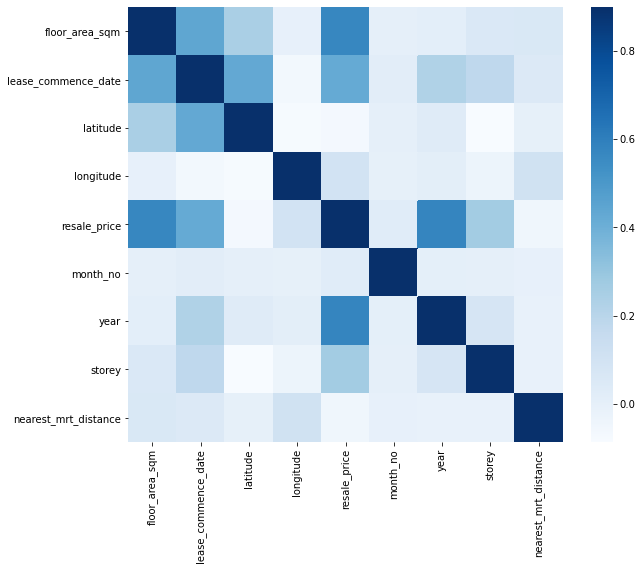

In [31]:
corr = train_df.corr()
plt.subplots(figsize=(10,8))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [32]:
corr[['resale_price']].sort_values(by='resale_price',ascending=False)[7:8].style.background_gradient(cmap='viridis', axis=None)

,resale_price
nearest_mrt_distance,-0.046656


### Reduce the size of dataframe to save memory during training

In [33]:
train_df, _ = reduce_memory_usage(train_df)
test_df, _ = reduce_memory_usage(test_df)

Memory usage of properties dataframe is : 64.23014831542969  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  46.937416076660156  MB
This is  73.07692307692308 % of the initial size
Memory usage of properties dataframe is : 15.234214782714844  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  11.32272720336914  MB
This is  74.32432432432432 % of the initial size


### Segregate the columns

In [34]:
integer_columns = [
    "lease_commence_date",
    "storey",
    "month_no",
    "year",
    "nearest_mrt_distance"
]

float_columns = [
    "floor_area_sqm",
]

target_column = [
    "resale_price"
]

## Categorical columns need to be encoded before training
categorical_columns = [
    "town",
    "flat_type",
    "flat_model",
    "subzone",
    "planning_area",
    "region"
]

## We will drop these columns before training
drop_columns = [
    "lat_long",
    "block",
    "street_name",
    "nearest_mrt",
    #"longitude",
    #"latitude"
]

### Drop the selected columns

In [35]:
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)

### One hot encode categorical columns

In [36]:
for col in categorical_columns:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[col], prefix=col)],axis=1)
train_df = train_df.drop(columns=categorical_columns)

for col in categorical_columns:
    test_df = pd.concat([test_df, pd.get_dummies(test_df[col], prefix=col)],axis=1)
test_df = test_df.drop(columns=categorical_columns)

### Check if the columns in both test data and train data are same after one-hot encoding

In [37]:
columns_in_test_not_in_train = test_df.columns.difference(train_df.columns).tolist()
#print(columns_in_test_not_in_train)
columns_in_train_not_in_test = train_df.columns.difference((test_df.columns)).tolist()
columns_in_train_not_in_test.remove('resale_price')
#print(columns_in_train_not_in_test)
if not columns_in_test_not_in_train and not columns_in_train_not_in_test:
    print("Columns are same")

Columns are same


### Split training data into training and validation sets

In [38]:
train_data = train_df.sample(frac=1)
train_labels = train_data.pop('resale_price')
train_x, val_x, train_y, val_y = train_test_split(train_data,train_labels,train_size=0.8)

----------------

## Decision Tree

#### Modify max_depth and min_samples_split and train model

In [39]:
%time
dt_3 = tree.DecisionTreeRegressor(max_depth=250,min_samples_split=15)
dt_3 = dt_3.fit(train_x, train_y)

Wall time: 0 ns


In [40]:
train_prediction = dt_3.predict(train_x)
val_prediction = dt_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 13346.037423188613
Validation error(RMSE) : 22684.883219810254
R2 score for training data : 0.989439493276247
R2 score for validation data : 0.9694698843951672


#### Modify max_depth, max_feature and min_samples_split and train model

In [41]:
%%time
dt_4 = tree.DecisionTreeRegressor(max_depth=250,min_samples_split=10,max_features=50)
dt_4 = dt_4.fit(train_x, train_y)

Wall time: 3.01 s


In [42]:
train_prediction = dt_4.predict(train_x)
val_prediction = dt_4.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 16590.089764119533
Validation error(RMSE) : 26050.26781379729
R2 score for training data : 0.9836816008231056
R2 score for validation data : 0.9597394468020435


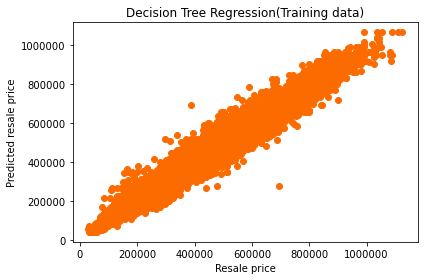

In [49]:
#plt.figure(figsize=(10,8))
plt.scatter(x=train_y,y=train_prediction, color = '#FC6B00')
#plt.scatter(val_prediction, val_y, color = 'green')
plt.title('Decision Tree Regression(Training data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
#plt.savefig("./dt_4_mrt_training_data.tiff",dpi=300)
plt.show()

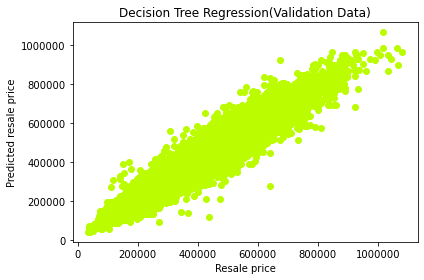

In [50]:
plt.scatter(x=val_y,y=val_prediction, color = '#BBFC00')
plt.title('Decision Tree Regression(Validation Data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
#plt.savefig("./dt_4_mrt_validation_data.tiff",dpi=300)
plt.show()

In [51]:
dt_4_feature_importance = pd.DataFrame({'Feature':train_x.columns,'Importance':dt_4.feature_importances_}).sort_values('Importance', ascending=False)

In [52]:
dt_4_feature_importance.head()

,Feature,Importance
5,year,0.419201
0,floor_area_sqm,0.275998
248,region_central region,0.069189
36,flat_type_3-room,0.031309
1,lease_commence_date,0.024887


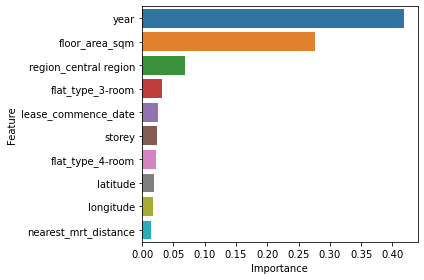

In [53]:
sns.barplot(y='Feature', x='Importance', data=dt_4_feature_importance.head(10))
plt.tight_layout()
#plt.savefig("./dt_4_mrt_feature_importance.tiff",dpi=300)

#### Uncomment next block to make prediction on test data and generate csv

In [154]:
#test_result = dt_3.predict(test_df)
#save_to_csv(test_result,"./mrt_dt_3_result.csv")

---------------

## Random Forest

#### Run model using default hyperparameters

In [155]:
rf_1 = RandomForestRegressor()

In [156]:
%%time
rf_1.fit(train_x,train_y)

Wall time: 11min 8s


RandomForestRegressor()

In [194]:
train_prediction = rf_1.predict(train_x)
val_prediction = rf_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 6961.906091806277
Validation error(RMSE) : 18410.213075736534
R2 score for training data : 0.9971285896645732
R2 score for validation data : 0.9798284079706304


#### Modify max_depth and n_estimators train model

In [54]:
rf_2 = RandomForestRegressor(n_estimators=50,max_depth=10,n_jobs=-1,verbose=1)

In [55]:
%%time
rf_2.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min


Wall time: 1min 57s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished


RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, verbose=1)

In [56]:
train_prediction = rf_2.predict(train_x)
val_prediction = rf_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Training error(RMSE) : 31644.984443821028
Validation error(RMSE) : 32235.68547004822
R2 score for training data : 0.9406268823858679
R2 score for validation data : 0.9383505548503839


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


#### Modify max_depth and n_estimators train model

In [57]:
rf_3 = RandomForestRegressor(n_estimators=50,max_depth=50,n_jobs=-1,verbose=1)

In [58]:
%%time
rf_3.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min


Wall time: 2min 26s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.4min finished


RandomForestRegressor(max_depth=50, n_estimators=50, n_jobs=-1, verbose=1)

In [59]:
train_prediction = rf_3.predict(train_x)
val_prediction = rf_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished


Training error(RMSE) : 7018.560976959385
Validation error(RMSE) : 18258.522591548564
R2 score for training data : 0.9970793720597247
R2 score for validation data : 0.9802218065945282


#### Modify max_depth and n_estimators train model

In [60]:
rf_4 = RandomForestRegressor(n_estimators=50,max_depth=50,max_features=50,n_jobs=-1,verbose=1)

In [61]:
%%time
rf_4.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.4s


Wall time: 50.3 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   49.9s finished


RandomForestRegressor(max_depth=50, max_features=50, n_estimators=50, n_jobs=-1,
                      verbose=1)

In [62]:
train_prediction = rf_4.predict(train_x)
val_prediction = rf_4.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s


Training error(RMSE) : 7361.973369601116
Validation error(RMSE) : 18855.17981940528
R2 score for training data : 0.9967865720627616
R2 score for validation data : 0.9789080511159132


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.7s finished


In [63]:
feature_importance_rf_4 = pd.DataFrame({'Feature':train_x.columns,'Importance':rf_4.feature_importances_}).sort_values('Importance', ascending=False)

In [64]:
feature_importance_rf_4.head(10)

,Feature,Importance
5,year,0.373520
0,floor_area_sqm,0.157752
36,flat_type_3-room,0.063339
1,lease_commence_date,0.060406
248,region_central region,0.039241
2,latitude,0.036214
37,flat_type_4-room,0.035629
38,flat_type_5-room,0.031070
39,flat_type_executive,0.030485
3,longitude,0.022283


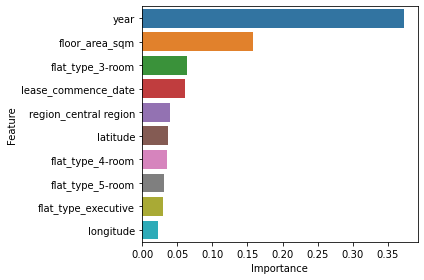

In [66]:
sns.barplot(y='Feature', x='Importance', data=feature_importance_rf_4.head(10))
plt.tight_layout()
#plt.savefig("./rf_4_mrt_feature_importance.tiff",dpi=300)

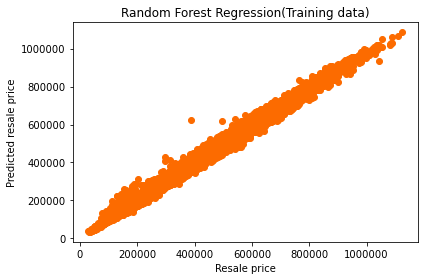

In [67]:
plt.scatter(x=train_y,y=train_prediction, color = '#FC6B00')
#plt.scatter(val_prediction, val_y, color = 'green')
plt.title('Random Forest Regression(Training data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
#plt.savefig("./rf_4_mrt_training_data.tiff",dpi=300)
plt.show()

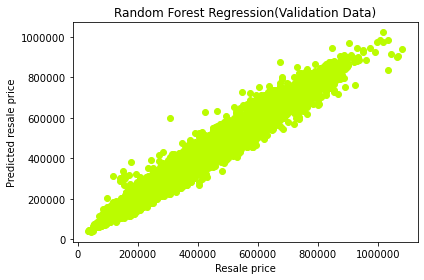

In [68]:
plt.scatter(x=val_y,y=val_prediction, color = '#BBFC00')
plt.title('Random Forest Regression(Validation Data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
#plt.savefig("./rf_4_mrt_validation_data.tiff",dpi=300)
plt.show()

#### Uncomment next block to make prediction on test data and generate csv

In [54]:
#test_result = rf_1.predict(test_df)
#save_to_csv(test_result,"./mrt_rf_1_result.csv")

------------

## XGBOOST

In [69]:
xgb_model_2 = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=50,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [70]:
%%time
xgb_model_2.fit(train_x,train_y)

Wall time: 4min 17s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=50,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [71]:
feature_importance_xgb = pd.DataFrame({'Variable':train_x.columns,'Importance':xgb_model_2.feature_importances_}).sort_values('Importance', ascending=False)

In [72]:
feature_importance_xgb.head(20)

,Variable,Importance
36,flat_type_3-room,0.230323
39,flat_type_executive,0.143314
34,flat_type_1-room,0.059494
44,flat_model_dbss,0.042083
47,flat_model_maisonette,0.039117
38,flat_type_5-room,0.028132
58,flat_model_terrace,0.027449
59,flat_model_type s1,0.026306
248,region_central region,0.021311
43,flat_model_apartment,0.020625


In [73]:
train_prediction = xgb_model_2.predict(train_x)
val_prediction = xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 9987.102
Validation error(RMSE) : 22111.135
R2 score for training data : 0.994086303767447
R2 score for validation data : 0.9709947019156123


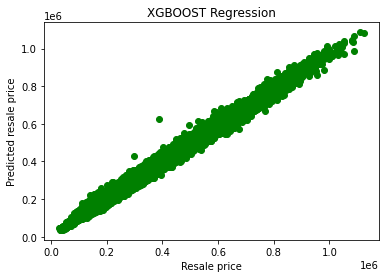

In [74]:
plt.scatter(train_y,train_prediction, color = 'green')
plt.title('XGBOOST Regression')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.show()

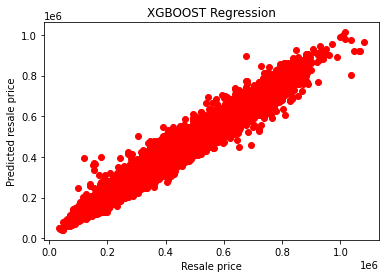

In [75]:
plt.scatter(val_y,val_prediction, color = 'red')
plt.title('XGBOOST Regression')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.show()

#### Uncomment next block to make prediction on test data and generate csv

In [179]:
#test_result = xgb_model_2.predict(test_df)
#save_to_csv(test_result,"./mrt_xgb_model_2_result.csv")

------------------

## LightGBM

In [76]:
gbm_1 = lgb.LGBMRegressor()

In [77]:
%%time
gbm_1 = gbm_1.fit(train_x,train_y)

Wall time: 2.27 s


In [78]:
train_prediction = gbm_1.predict(train_x)
val_prediction = gbm_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 22685.404337613745
Validation error(RMSE) : 22971.166023010017
R2 score for training data : 0.9694878275976618
R2 score for validation data : 0.9686944430697964


In [79]:
gbm_2 = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.1,
                        max_depth=10000,n_estimators=10000)

In [80]:
%%time
gbm_2 = gbm_2.fit(train_x,train_y)

Wall time: 57.1 s


In [81]:
feature_importance_gbm_2 = pd.DataFrame({'Feature':train_x.columns,'Importance':gbm_2.feature_importances_}).sort_values('Importance', ascending=False)

In [82]:
feature_importance_gbm_2.head(10)

,Feature,Importance
5,year,62947
0,floor_area_sqm,39158
7,nearest_mrt_distance,36836
4,month_no,35330
2,latitude,27604
6,storey,25219
3,longitude,22761
1,lease_commence_date,14392
37,flat_type_4-room,2067
45,flat_model_improved,1861


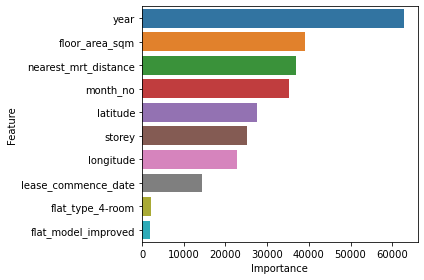

In [83]:
sns.barplot(y='Feature', x='Importance', data=feature_importance_gbm_2.head(10))
plt.tight_layout()
#plt.savefig("./gbm_2_mrt_feature_importance.tiff",dpi=300)

In [84]:
train_prediction = gbm_2.predict(train_x)
val_prediction = gbm_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 11579.754107800514
Validation error(RMSE) : 16061.50152580776
R2 score for training data : 0.992049787159993
R2 score for validation data : 0.984695200672435


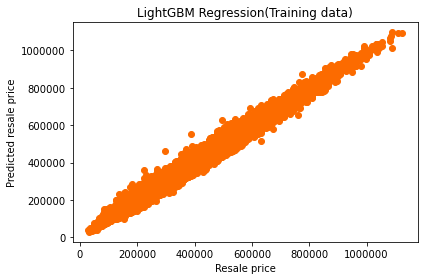

In [85]:
#plt.figure(figsize=(10,8))
plt.scatter(x=train_y,y=train_prediction, color = '#FC6B00')
#plt.scatter(val_prediction, val_y, color = 'green')
plt.title('LightGBM Regression(Training data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
#plt.savefig("./gbm_2_mrt_training_data.tiff",dpi=300)
plt.show()

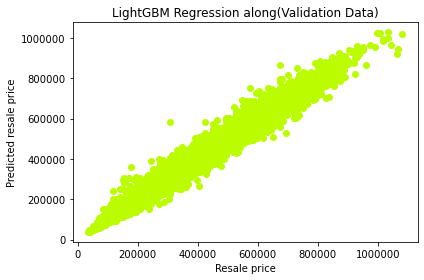

In [86]:
plt.scatter(x=val_y,y=val_prediction, color = '#BBFC00')
plt.title('LightGBM Regression along(Validation Data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
#plt.savefig("./gbm_2_mrt_validation_data.tiff",dpi=300)
plt.show()

In [87]:
%%time
gbm_3 = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.1,
                        max_depth=10000,n_estimators=10000)

Wall time: 0 ns


In [88]:
gbm_3.fit(
    train_x, train_y, 
    eval_set= [(train_x, train_y), (val_x, val_y)], 
    eval_metric='rmse', verbose=1000)

[1000]	training's rmse: 16469.2	training's l2: 2.71236e+08	valid_1's rmse: 17412.7	valid_1's l2: 3.03202e+08
[2000]	training's rmse: 15148.1	training's l2: 2.29465e+08	valid_1's rmse: 16673.9	valid_1's l2: 2.78018e+08
[3000]	training's rmse: 14315.3	training's l2: 2.04929e+08	valid_1's rmse: 16359.4	valid_1's l2: 2.6763e+08
[4000]	training's rmse: 13717.6	training's l2: 1.88172e+08	valid_1's rmse: 16207.4	valid_1's l2: 2.62678e+08
[5000]	training's rmse: 13236.7	training's l2: 1.7521e+08	valid_1's rmse: 16125.1	valid_1's l2: 2.60018e+08
[6000]	training's rmse: 12821.2	training's l2: 1.64382e+08	valid_1's rmse: 16073.7	valid_1's l2: 2.58364e+08
[7000]	training's rmse: 12453.1	training's l2: 1.5508e+08	valid_1's rmse: 16052.6	valid_1's l2: 2.57687e+08
[8000]	training's rmse: 12127.2	training's l2: 1.47069e+08	valid_1's rmse: 16041.2	valid_1's l2: 2.57319e+08
[9000]	training's rmse: 11847	training's l2: 1.40351e+08	valid_1's rmse: 16045.1	valid_1's l2: 2.57445e+08
[10000]	training's rmse:

LGBMRegressor(max_depth=10000, n_estimators=10000)

In [89]:
train_prediction = gbm_3.predict(train_x)
val_prediction = gbm_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 11579.754107800514
Validation error(RMSE) : 16061.50152580776
R2 score for training data : 0.992049787159993
R2 score for validation data : 0.984695200672435


#### Uncomment next block to make prediction on test data and generate csv

In [129]:
#test_result = gbm_2.predict(test_df)
#save_to_csv(test_result,"./mrt_gbm_2_result_70_30.csv")

------------------------

## Prediction using Random Forest, XGBOOST and LightGBM together

In [91]:
train_prediction = 0.4*gbm_2.predict(train_x) + 0.4*rf_4.predict(train_x) +0.2*xgb_model_2.predict(train_x)
val_prediction = 0.4*gbm_2.predict(val_x)+ 0.4*rf_4.predict(val_x) +0.2*xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.7s finished


Training error(RMSE) : 8642.157739370079
Validation error(RMSE) : 16801.67934103083
R2 score for training data : 0.9955718282329636
R2 score for validation data : 0.9832520854286445


#### Uncomment next block to make prediction on test data and generate csv

In [84]:
#test_result = 0.4*gbm_2.predict(test_df) + 0.4*rf_1.predict(test_df) +0.2*xgb_model_2.predict(test_df)
#save_to_csv(test_result,"./mrt_gbm_2_xgb_model_2_rf_1_result.csv")